# Notebook 2: Training Transolver on Stokes Flow

**Goal:** Train a Transolver model and visualize how it learns to partition the mesh into physics-based slices.

## Outline
1. Load Stokes Flow Dataset
2. Transolver Model (PhysicsNeMo)
3. Training Loop (200 Epochs)
4. Visualize Learned Slice Assignments

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import download_stokes_dataset, load_stokes_sample, get_num_samples

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Load Stokes Flow Dataset

We'll use the same dataset from Lab 4: Stokes flow around obstacles with varying geometries.

In [2]:
# Download and load dataset
download_stokes_dataset()

# Load multiple samples for training
num_samples = max(1, min(get_num_samples(), 50))  # Use up to 50 samples
print(f"Loading {num_samples} samples...")

train_data = []
for i in range(num_samples):
    coords, u, v, p = load_stokes_sample(sample_idx=i)
    train_data.append({
        'coords': torch.tensor(coords, dtype=torch.float32),
        'targets': torch.tensor(np.stack([u, v, p], axis=1), dtype=torch.float32)
    })

# Use first sample for visualization
sample_coords = train_data[0]['coords']
sample_targets = train_data[0]['targets']
N = len(sample_coords)
print(f"✓ Loaded {num_samples} samples, each with ~{N} mesh points")
print(f"  Input: coordinates (N, 2)")
print(f"  Output: u, v, p (N, 3)")

✓ Dataset already exists at ../lab_4/dataset (100 VTP files)
Loading 50 samples...
✓ Loaded res_0.vtp (3343 points)
✓ Loaded res_1.vtp (3254 points)
✓ Loaded res_10.vtp (3354 points)
✓ Loaded res_100.vtp (3296 points)
✓ Loaded res_101.vtp (3256 points)
✓ Loaded res_102.vtp (3332 points)
✓ Loaded res_103.vtp (3340 points)
✓ Loaded res_104.vtp (3317 points)
✓ Loaded res_105.vtp (3317 points)
✓ Loaded res_106.vtp (3300 points)
✓ Loaded res_107.vtp (3280 points)
✓ Loaded res_108.vtp (3336 points)
✓ Loaded res_109.vtp (3242 points)
✓ Loaded res_11.vtp (3280 points)
✓ Loaded res_110.vtp (3366 points)
✓ Loaded res_111.vtp (3296 points)
✓ Loaded res_112.vtp (3317 points)
✓ Loaded res_113.vtp (3297 points)
✓ Loaded res_114.vtp (3289 points)
✓ Loaded res_115.vtp (3330 points)
✓ Loaded res_116.vtp (3283 points)
✓ Loaded res_117.vtp (3247 points)
✓ Loaded res_118.vtp (3299 points)
✓ Loaded res_119.vtp (3314 points)
✓ Loaded res_12.vtp (3315 points)
✓ Loaded res_120.vtp (3291 points)
✓ Loaded res_1

## 2. Transolver Model

We'll try to use PhysicsNeMo's Transolver if available, otherwise fall back to a simple implementation.

In [3]:
# Import PhysicsNeMo Transolver
from physicsnemo.models.transolver import Transolver

# Model configuration
NUM_SLICES = 32  # Number of learned slices
HIDDEN_DIM = 128
NUM_LAYERS = 4
NUM_HEADS = 8

print("✓ PhysicsNeMo Transolver imported")
print(f"  Config: hidden_dim={HIDDEN_DIM}, layers={NUM_LAYERS}, slices={NUM_SLICES}, heads={NUM_HEADS}")

Warp DeprecationWarning: The namespace `warp.context` will soon be removed from the public API. It can still be accessed from `warp._src.context` but might be changed or removed without notice.
Warp DeprecationWarning: The symbol `warp.context.Device` will soon be removed from the public API. Use `warp.Device` instead.
✓ PhysicsNeMo Transolver imported
  Config: hidden_dim=128, layers=4, slices=32, heads=8


In [4]:
# Create PhysicsNeMo Transolver model
# For unstructured meshes: embedding_dim=2 (x,y coordinates), functional_dim=0 (no additional input features)
model = Transolver(
    functional_dim=0,           # No functional input, just coordinates
    out_dim=3,                  # Output: u, v, p
    embedding_dim=2,            # 2D coordinates as embeddings
    n_layers=NUM_LAYERS,
    n_hidden=HIDDEN_DIM,
    n_head=NUM_HEADS,
    slice_num=NUM_SLICES,
    unified_pos=False,          # We provide our own embeddings (coordinates)
    structured_shape=None,      # Irregular/unstructured mesh
    use_te=False,               # Don't require transformer engine
).to(device)

# Storage for captured slice weights
captured_slice_weights = {}

def capture_slice_weights_hook(module, input, output):
    """Hook to capture slice weights from PhysicsAttention forward pass."""
    # The slice weights are computed in compute_slices_from_projections
    # We need to access them through the module's internal state
    # After forward, we can recompute them from the stored projections
    pass

# Helper function to get slice weights by running a modified forward pass
def get_slice_weights(model, coords):
    """
    Extract slice weights from the first PhysicsAttention layer.
    
    PhysicsNeMo's Transolver computes slice_weights internally in each block's Attn module.
    We access the first block and manually compute slice weights from the projections.
    """
    model.eval()
    with torch.no_grad():
        # Prepare input (PhysicsNeMo expects: fx=functional_input, embedding=spatial_coords)
        B, N, _ = coords.shape
        fx = torch.zeros(B, N, 0, device=coords.device)  # Empty functional input
        embedding = coords  # Coordinates as embeddings
        
        # Run through preprocessing
        fx_combined = torch.cat((embedding, fx), -1)  # (B, N, 2)
        h = model.preprocess(fx_combined)  # (B, N, hidden_dim)
        
        # Get first block's attention module
        first_block = model.blocks[0]
        attn_module = first_block.Attn
        
        # Run through LayerNorm
        h_normed = first_block.ln_1(h)
        
        # Project to head dimension (PhysicsNeMo internal)
        x_mid = attn_module.in_project_x(h_normed)
        x_mid = x_mid.view(B, N, attn_module.heads, attn_module.dim_head)
        
        # Compute slice projections
        slice_projections = attn_module.in_project_slice(x_mid)  # (B, N, heads, slices)
        
        # Compute slice weights (temperature-scaled softmax)
        temp = torch.clamp(attn_module.temperature, min=0.5, max=5)
        slice_weights = F.softmax(slice_projections / temp, dim=-1)  # (B, N, heads, slices)
        
        # Average across heads for visualization
        slice_weights_avg = slice_weights.mean(dim=2)  # (B, N, slices)
        
        return slice_weights_avg

n_params = sum(p.numel() for p in model.parameters())
print(f"✓ PhysicsNeMo Transolver created: {n_params:,} parameters")
print(f"  Architecture: {NUM_LAYERS} layers × {NUM_HEADS} heads × {NUM_SLICES} slices")

✓ PhysicsNeMo Transolver created: 766,627 parameters
  Architecture: 4 layers × 8 heads × 32 slices


## 3. Train for 20 Epochs

We'll train the model and track how the slice assignments evolve during training.

In [5]:
# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

NUM_EPOCHS = 200
losses = []
slice_history = []  # Store slice assignments at different epochs
field_history = []  # Store u, v, p predictions at same epochs for visualization

# 5 snapshot epochs: 0 (untrained) + 4 spread across training, always including final epoch
SNAPSHOT_EPOCHS = sorted(set([0, NUM_EPOCHS//4, NUM_EPOCHS//2, 3*NUM_EPOCHS//4, NUM_EPOCHS]))

# Get initial slice assignments and field predictions (before training)
x = sample_coords.unsqueeze(0).to(device)
initial_slices = get_slice_weights(model, x)[0].cpu().numpy()
slice_history.append(('Epoch 0 (untrained)', initial_slices))
with torch.no_grad():
    fx0 = torch.zeros(1, x.shape[1], 0, device=device)
    pred0 = model(fx0, embedding=x)[0].cpu().numpy()  # (N, 3)
field_history.append((pred0[:, 0], pred0[:, 1], pred0[:, 2]))

print("Training PhysicsNeMo Transolver...")
print("-" * 50)

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    
    # Shuffle data each epoch
    indices = np.random.permutation(len(train_data))
    
    for idx in indices:
        data = train_data[idx]
        coords = data['coords'].unsqueeze(0).to(device)  # (1, N, 2) - used as embedding
        targets = data['targets'].unsqueeze(0).to(device)  # (1, N, 3)
        
        # PhysicsNeMo Transolver forward: fx=None (no functional input), embedding=coords
        optimizer.zero_grad()
        B, N, _ = coords.shape
        fx = torch.zeros(B, N, 0, device=device)  # Empty functional input
        pred = model(fx, embedding=coords)
        loss = criterion(pred, targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_data)
    losses.append(avg_loss)
    
    # Save slice assignments and u, v, p predictions at the 5 snapshot epochs (including final)
    if (epoch + 1) in SNAPSHOT_EPOCHS and (epoch + 1) != 0:
        x = sample_coords.unsqueeze(0).to(device)
        slices = get_slice_weights(model, x)[0].cpu().numpy()
        slice_history.append((f'Epoch {epoch+1}', slices))
        with torch.no_grad():
            fx = torch.zeros(1, x.shape[1], 0, device=device)
            pred = model(fx, embedding=x)[0].cpu().numpy()  # (N, 3)
        field_history.append((pred[:, 0], pred[:, 1], pred[:, 2]))
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS}: Loss = {avg_loss:.6f}")

print("-" * 50)
print(f"✓ Training complete! Final loss: {losses[-1]:.6f}")

Training PhysicsNeMo Transolver...
--------------------------------------------------
Epoch   1/200: Loss = 0.076431
Epoch  10/200: Loss = 0.019847
Epoch  20/200: Loss = 0.018092
Epoch  30/200: Loss = 0.018090
Epoch  40/200: Loss = 0.017748
Epoch  50/200: Loss = 0.017082
Epoch  60/200: Loss = 0.016765
Epoch  70/200: Loss = 0.016054
Epoch  80/200: Loss = 0.016707
Epoch  90/200: Loss = 0.016433
Epoch 100/200: Loss = 0.013610
Epoch 110/200: Loss = 0.013107
Epoch 120/200: Loss = 0.012952
Epoch 130/200: Loss = 0.013100
Epoch 140/200: Loss = 0.013175
Epoch 150/200: Loss = 0.012986
Epoch 160/200: Loss = 0.012754
Epoch 170/200: Loss = 0.013166
Epoch 180/200: Loss = 0.012562
Epoch 190/200: Loss = 0.012753
Epoch 200/200: Loss = 0.013397
--------------------------------------------------
✓ Training complete! Final loss: 0.013397


## Summary & Key Takeaways

Let's see how the model learned to partition the mesh during training.

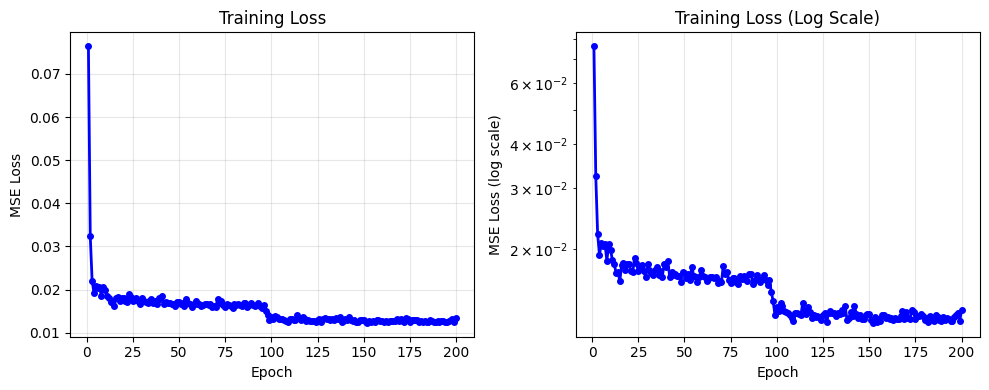

In [6]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS+1), losses, 'b-o', linewidth=2, markersize=4)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(range(1, NUM_EPOCHS+1), losses, 'b-o', linewidth=2, markersize=4)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.title('Training Loss (Log Scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

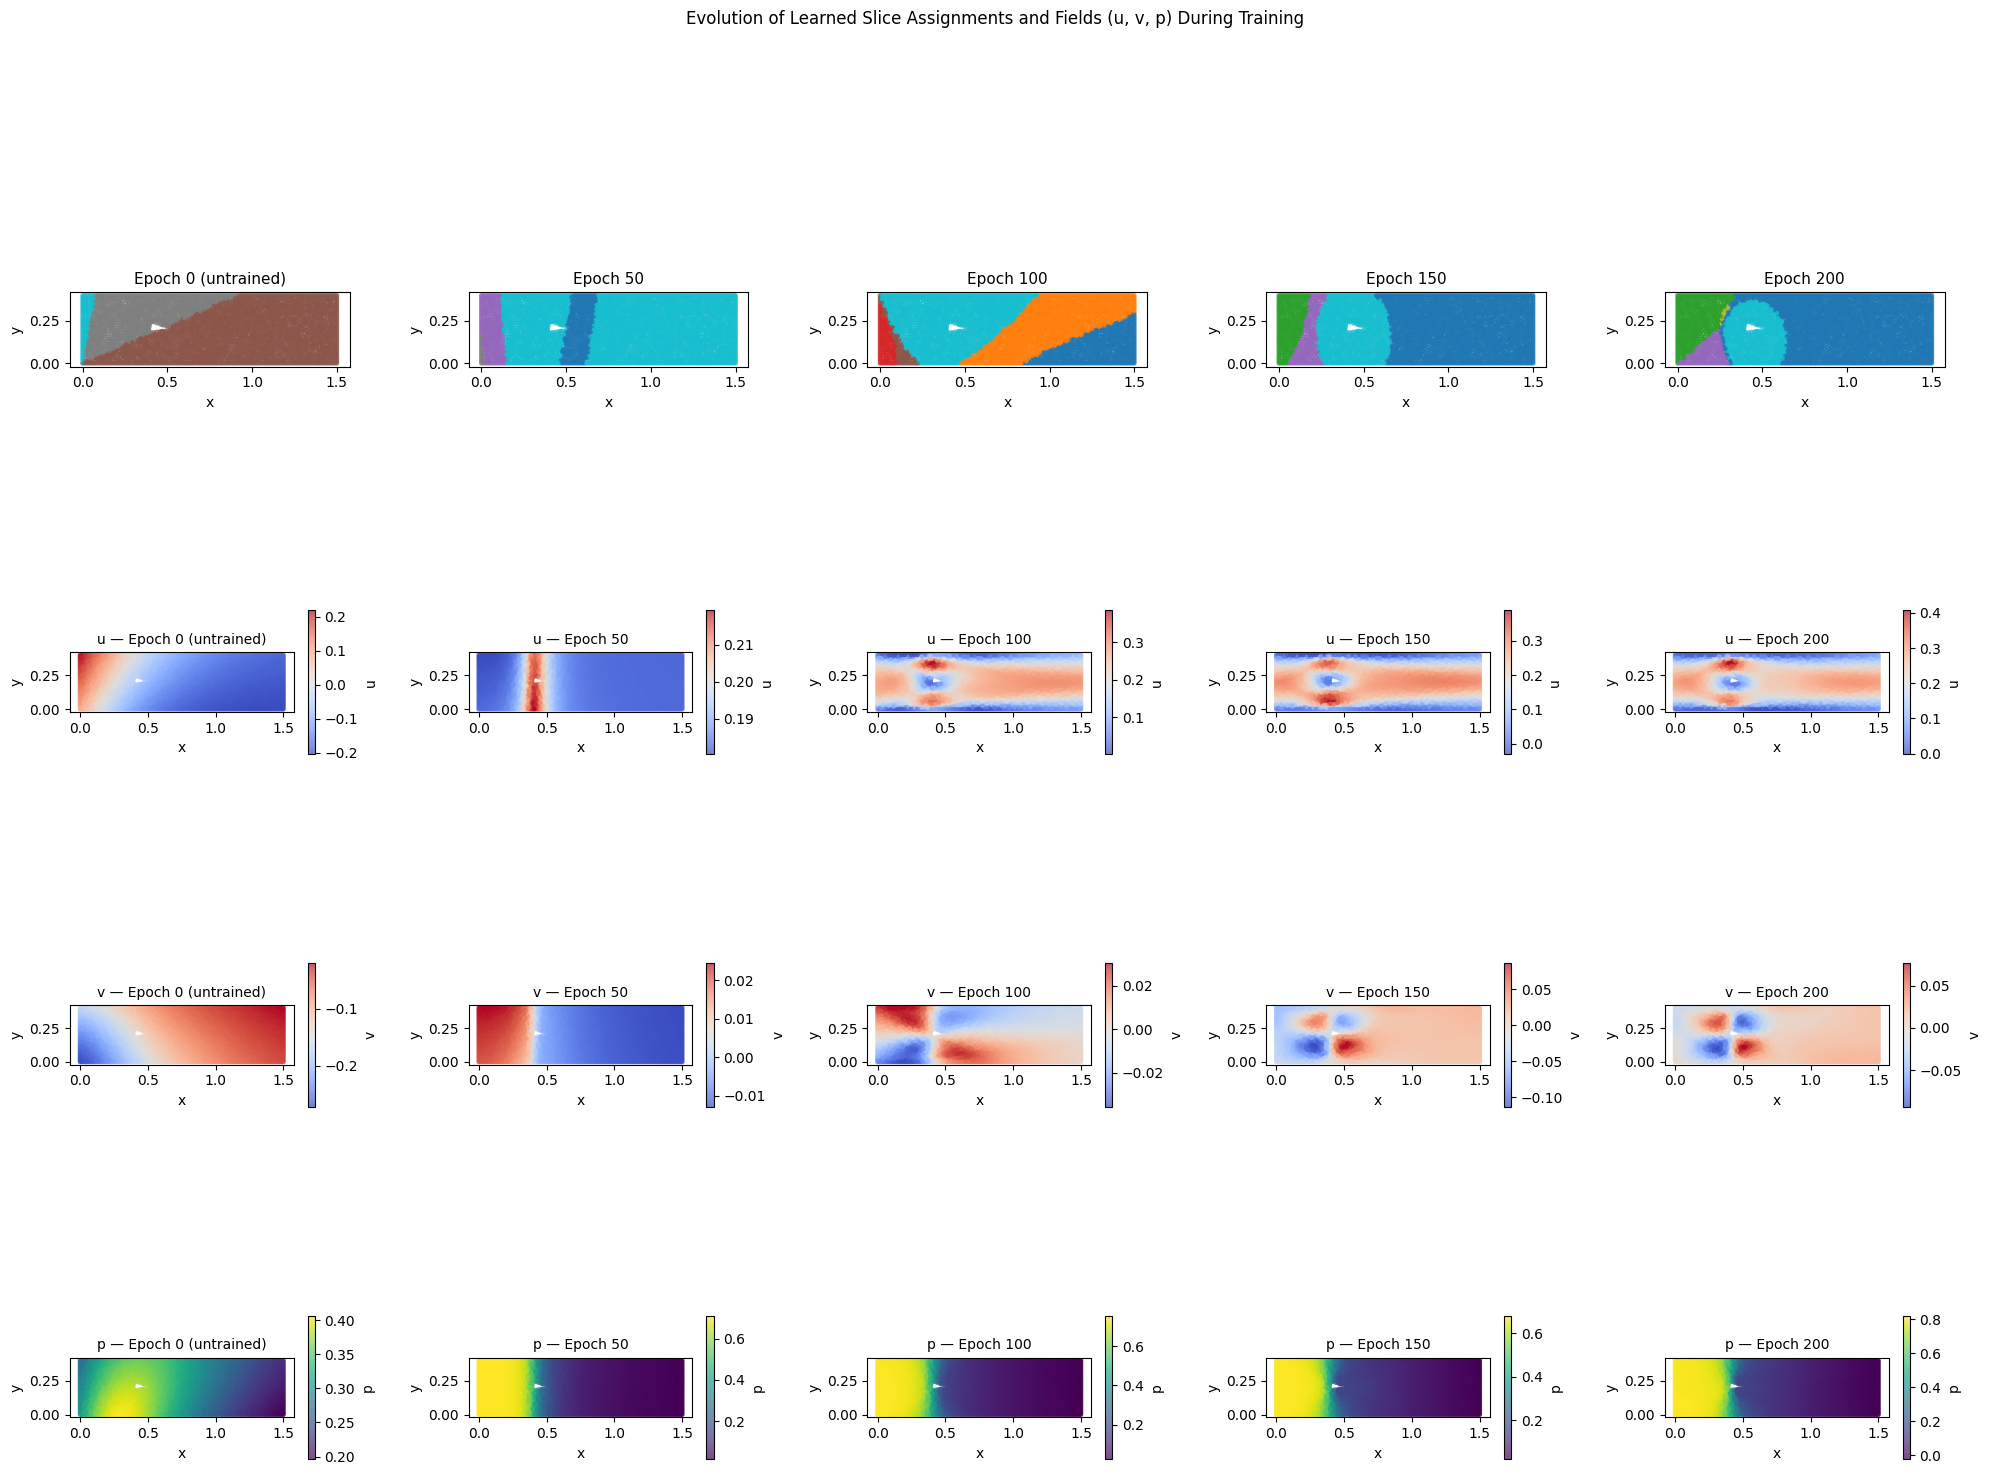

Notice how slices become more spatially coherent as training progresses!


In [11]:
"""
Visualize slice assignments and u, v, p at different epochs.
Requires:
  - sample_coords: tensor or array, shape (n_points, 2)
  - slice_history: list of (title, slice_weights) with slice_weights (n_points, n_slices)
  - field_history: list of (u_vals, v_vals, p_vals) or list of dicts {'u': ..., 'v': ..., 'p': ...}
                   same length as slice_history; each u/v/p array shape (n_points,)
"""
import numpy as np
import matplotlib.pyplot as plt

# --- Your existing data (adapt variable names / sources as needed) ---
# sample_coords = ...   # (n_points, 2)
# slice_history = [(title, slice_weights), ...]
# field_history = [(u_vals, v_vals, p_vals), ...]  # one per snapshot

coords_np = sample_coords.numpy() if hasattr(sample_coords, 'numpy') else np.asarray(sample_coords)
num_snapshots = len(slice_history)

# field_history is filled during training (5 snapshots: 0 + spread across 1..NUM_EPOCHS including final)
field_history = globals().get('field_history', None)
has_fields = field_history is not None and len(field_history) == num_snapshots

if has_fields:
    n_rows = 4  # slice, u, v, p
else:
    n_rows = 1

fig, axes = plt.subplots(n_rows, num_snapshots, figsize=(4 * num_snapshots, 4 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for idx, (title, slice_weights) in enumerate(slice_history):
    # Row 0: dominant slice
    ax = axes[0, idx] if num_snapshots > 1 else axes[0, 0]
    dominant_slice = np.argmax(slice_weights, axis=1)
    scatter = ax.scatter(
        coords_np[:, 0], coords_np[:, 1], c=dominant_slice,
        cmap='tab10', s=6, alpha=0.7
    )
    ax.set_title(title, fontsize=11)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')

    # Rows 1–3: u, v, p at this epoch
    if has_fields:
        entry = field_history[idx]
        if isinstance(entry, dict):
            u_vals, v_vals, p_vals = entry['u'], entry['v'], entry['p']
        else:
            u_vals, v_vals, p_vals = entry[0], entry[1], entry[2]
        u_vals = np.asarray(u_vals).flatten()
        v_vals = np.asarray(v_vals).flatten()
        p_vals = np.asarray(p_vals).flatten()

        for row, (vals, label, cmap) in enumerate([
            (u_vals, 'u', 'coolwarm'),
            (v_vals, 'v', 'coolwarm'),
            (p_vals, 'p', 'viridis'),
        ], start=1):
            ax = axes[row, idx] if num_snapshots > 1 else axes[row, 0]
            sc = ax.scatter(
                coords_np[:, 0], coords_np[:, 1], c=vals,
                cmap=cmap, s=6, alpha=0.7
            )
            plt.colorbar(sc, ax=ax, label=label, shrink=0.3)
            ax.set_title(f'{label} — {title}', fontsize=10)
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_aspect('equal')

plt.suptitle(
    'Evolution of Learned Slice Assignments and Fields (u, v, p) During Training',
    fontsize=12, y=1.02
)
plt.tight_layout()
plt.show()

print("Notice how slices become more spatially coherent as training progresses!")


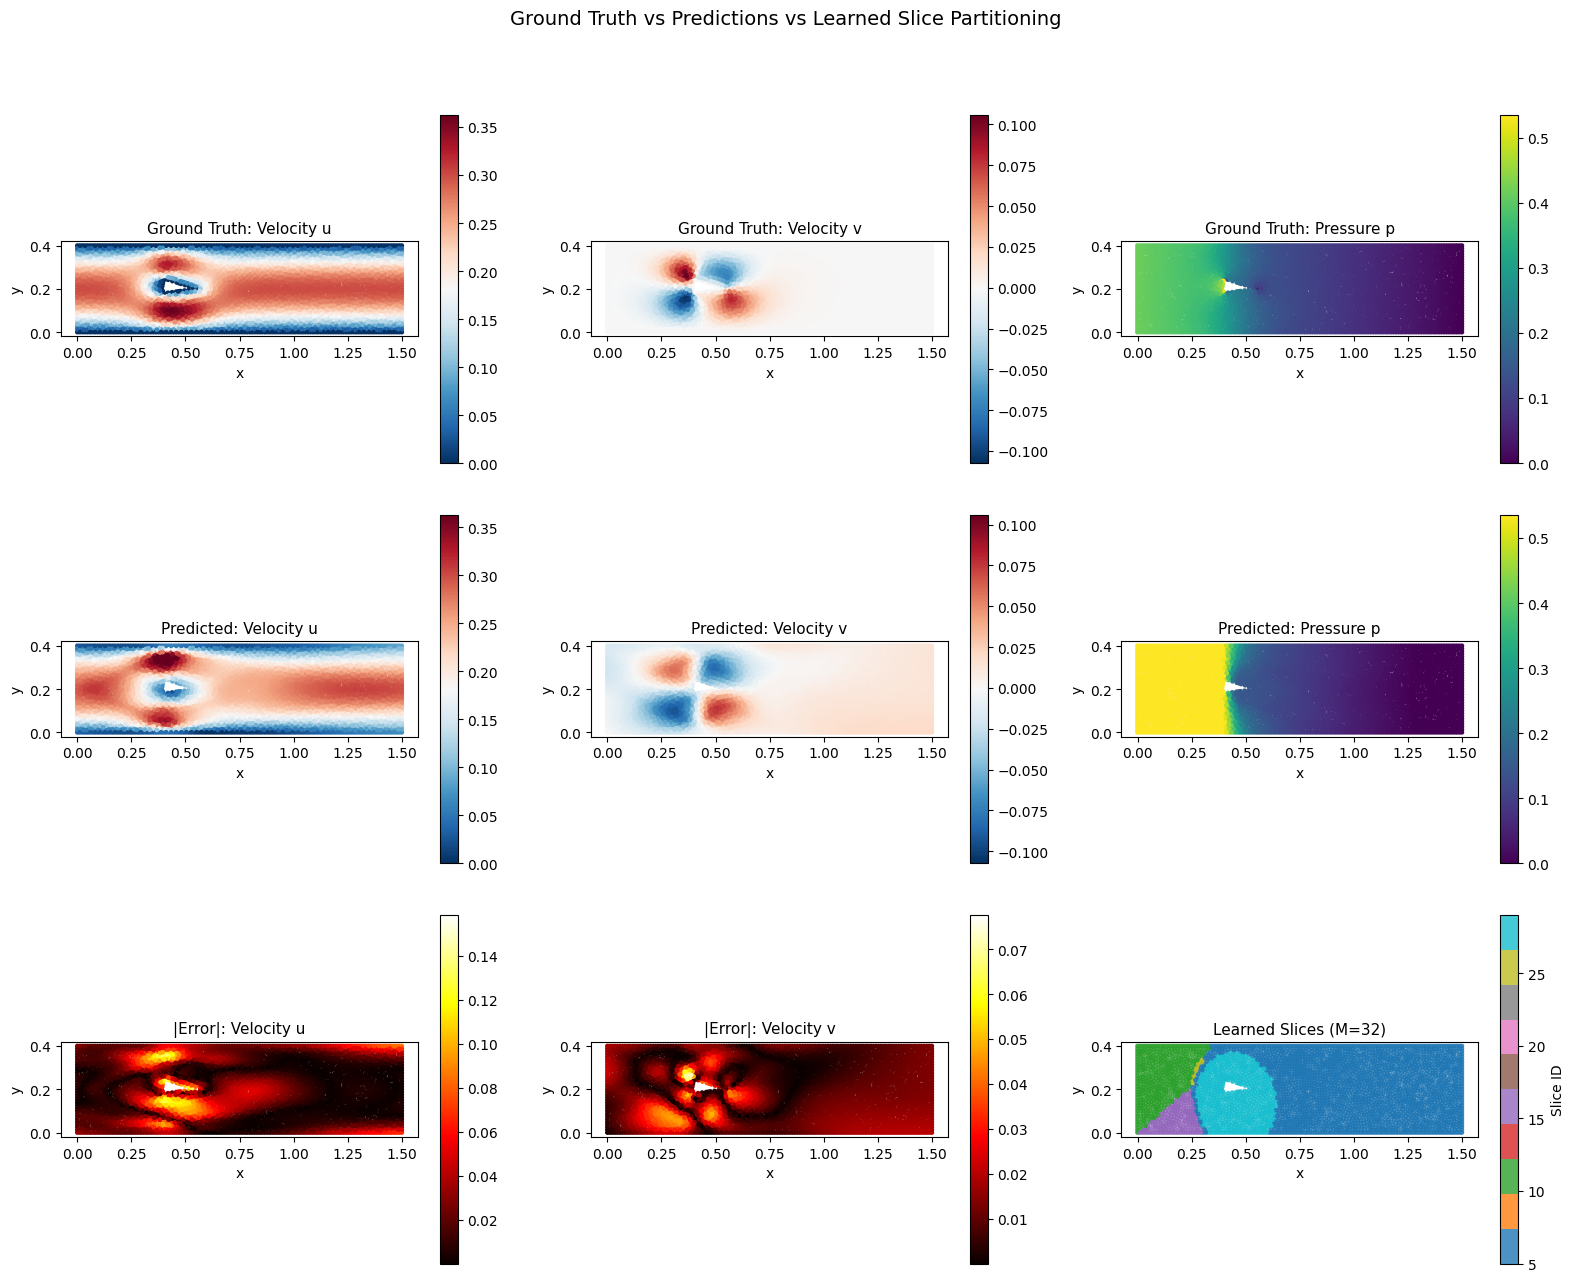

Row 1: Ground truth fields  |  Row 2: Model predictions  |  Row 3: Errors + Learned slices
Compare the slice boundaries with regions of high error and physical gradients!


In [8]:
# Final comparison: Ground Truth vs Predictions vs Learned Slices
# Get model predictions on the sample
model.eval()
with torch.no_grad():
    x_in = sample_coords.unsqueeze(0).to(device)
    B_in, N_in, _ = x_in.shape
    fx_in = torch.zeros(B_in, N_in, 0, device=device)
    pred_sample = model(fx_in, embedding=x_in)[0].cpu().numpy()  # (N, 3)

targets_np = sample_targets.numpy()

# Get final slice assignments
final_slices = slice_history[-1][1]
dominant_slice = np.argmax(final_slices, axis=1)

fig, axes = plt.subplots(3, 3, figsize=(16, 13))

fields = [
    ('Velocity u', 0, 'RdBu_r'),
    ('Velocity v', 1, 'RdBu_r'),
    ('Pressure p', 2, 'viridis'),
]

# Row 0: Ground Truth
for col, (name, idx, cmap) in enumerate(fields):
    ax = axes[0, col]
    vmin, vmax = targets_np[:, idx].min(), targets_np[:, idx].max()
    sc = ax.scatter(coords_np[:, 0], coords_np[:, 1], c=targets_np[:, idx],
                    cmap=cmap, s=6, vmin=vmin, vmax=vmax)
    ax.set_title(f'Ground Truth: {name}', fontsize=11)
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_aspect('equal')
    plt.colorbar(sc, ax=ax, shrink=0.8)

# Row 1: Predictions
for col, (name, idx, cmap) in enumerate(fields):
    ax = axes[1, col]
    vmin, vmax = targets_np[:, idx].min(), targets_np[:, idx].max()
    sc = ax.scatter(coords_np[:, 0], coords_np[:, 1], c=pred_sample[:, idx],
                    cmap=cmap, s=6, vmin=vmin, vmax=vmax)
    ax.set_title(f'Predicted: {name}', fontsize=11)
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_aspect('equal')
    plt.colorbar(sc, ax=ax, shrink=0.8)

# Row 2: Pointwise absolute errors + Learned Slices
for col, (name, idx, _) in enumerate(fields[:2]):
    ax = axes[2, col]
    error = np.abs(targets_np[:, idx] - pred_sample[:, idx])
    sc = ax.scatter(coords_np[:, 0], coords_np[:, 1], c=error, cmap='hot', s=6)
    ax.set_title(f'|Error|: {name}', fontsize=11)
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_aspect('equal')
    plt.colorbar(sc, ax=ax, shrink=0.8)

# Bottom-right: Learned slices
ax = axes[2, 2]
sc = ax.scatter(coords_np[:, 0], coords_np[:, 1], c=dominant_slice,
                cmap='tab10', s=6, alpha=0.8)
ax.set_title(f'Learned Slices (M={NUM_SLICES})', fontsize=11)
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_aspect('equal')
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
cbar.set_label('Slice ID')

plt.suptitle('Ground Truth vs Predictions vs Learned Slice Partitioning', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

print("Row 1: Ground truth fields  |  Row 2: Model predictions  |  Row 3: Errors + Learned slices")
print("Compare the slice boundaries with regions of high error and physical gradients!")

## Summary

**What we demonstrated:**
1. Trained a Transolver model on Stokes flow data for 20 epochs
2. Visualized how **slice assignments evolve** during training
3. The model learns to partition the mesh based on **physical behavior**, not just geometry

**Key observations:**
- Initially (untrained): slices are essentially random
- After training: slices align with physics (e.g., inlet, wake, boundaries)
- This learned partitioning enables efficient O(N·M) attention instead of O(N²)
**References:**
- [Transolver Paper](https://arxiv.org/abs/2402.02366)
